In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from astroML.classification import GMMBayes

from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from astroML.utils import split_samples, completeness_contamination
from astroML.datasets import fetch_rrlyrae_combined

In [3]:
X, y = fetch_rrlyrae_combined()
y = y.astype(int)
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],random_state=0)

[========================================]  78.8kb / 78.8kb   
downloading cross-matched SDSS/2MASS dataset from https://github.com/astroML/astroML-data/raw/main/datasets/stripe82calibStars_v2.6.dat.gz to C:\Users\ricca\astroML_data
[=========================================]  63.58Mb / 63.58Mb   
uncompressing file...


In [4]:
def compute_models(*args):
    names = []
    probs = []
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train, y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_test)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [11]:
names, probs = compute_models((GaussianNB, {}),
                              (LinearDiscriminantAnalysis, {}),
                              (QuadraticDiscriminantAnalysis, {}),
                              (LogisticRegression,
                               dict(class_weight='balanced')),
                              (KNeighborsClassifier,
                               dict(n_neighbors=10)),
                              (DecisionTreeClassifier,
                               dict(random_state=0, max_depth=12,
                                    criterion='entropy')),
                              (GMMBayes, dict(n_components=3, tol=1E-5,
                                              covariance_type='full')))

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
GMMBayes


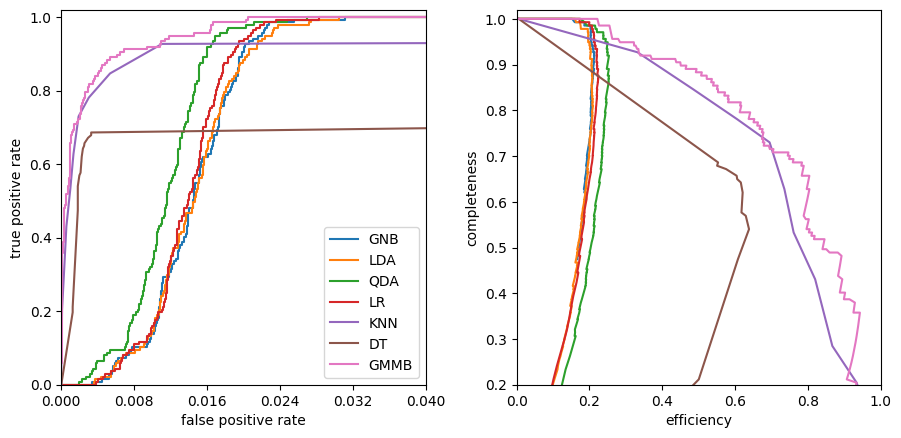

In [12]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# ax1 will show roc curves
ax1 = plt.subplot(131)

# ax2 will show completeness/efficiency
ax2 = plt.subplot(132)

# ax3 will show precision/recall
# ax3 = plt.subplot(133)

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

thresholds = np.linspace(0, 1, 1001)[:-1]

for name, y_prob in zip(names, probs):
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax1.plot(fpr, tpr, label=labels[name])

    #See note above about astroML vs. sklearn
    #Note that the range of threshhold values here is 0% to 100% (0.0 to 1.0)
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax2.plot(1 - cont, comp, label=labels[name])
    
    #ax3.plot(precision, recall, label=labels[name])
    
ax1.set_xlim(0, 0.04)
ax1.set_ylim(0, 1.02)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlabel('false positive rate')
ax1.set_ylabel('true positive rate')
ax1.legend(loc=4)

ax2.set_xlabel('efficiency')
ax2.set_ylabel('completeness')
ax2.set_xlim(0, 1.0)
ax2.set_ylim(0.2, 1.02)

#ax3.set_xlabel('precision')
#ax3.set_ylabel('recall')
#ax3.set_xlim(0, 1.0)
#ax3.set_ylim(0.2, 1.02)

plt.show()

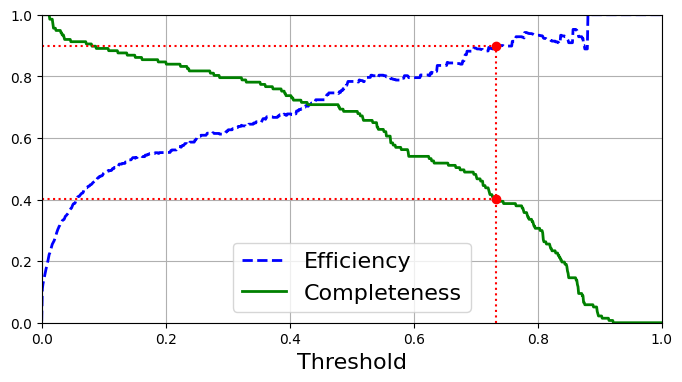

In [13]:
eff = 1-cont
def plot_comp_eff_vs_threshold(eff, comp, thresholds):
    plt.plot(thresholds, eff, "b--", label="Efficiency", linewidth=2)
    plt.plot(thresholds, comp, "g-", label="Completeness", linewidth=2)
    plt.legend(loc="best", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)                
    plt.axis([0, 1, 0, 1])             

comp_90_eff = comp[np.argmax(eff >= 0.90)]
threshold_90_eff = thresholds[np.argmax(eff >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_comp_eff_vs_threshold(eff, comp, thresholds)
plt.plot([threshold_90_eff, threshold_90_eff], [0., 0.9], "r:")                 
plt.plot([0, threshold_90_eff], [0.9, 0.9], "r:")                                
plt.plot([0, threshold_90_eff], [comp_90_eff, comp_90_eff], "r:")
plt.plot([threshold_90_eff], [0.9], "ro")                                             
plt.plot([threshold_90_eff], [comp_90_eff], "ro")                                                                          
plt.show()